In [1]:
import sys
import os
import time
import warnings 
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.plotting import scatter_matrix
import sklearn
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

2023-04-16 23:39:41.284367: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 23:39:41.323980: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 23:39:41.324762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 23:39:41.995257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.12.0
Numpy version:  1.23.5
Pandas version:  1.4.4
Scikit-learn version:  1.0.2


In [3]:
DATAPATH = './FDD/dataset'
SAVEPATH = './FDD/submissions'
TEST_SIZE = 0.05
RANDOM_SEED = 42

# 구현부

In [4]:
#################################추가적인 Feature Engineering Transformer를 만들어보고 성능을 테스트 하세요.#################################

class PressureAttrTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, x):
        pressure = (x['out_pressure']==0.7)
        return np.c_[x.drop(['out_pressure'], axis=1), pressure]
    
class LinearAttrTransformer(BaseEstimator, TransformerMixin): 
    """
    각 피쳐끼리 나누어주는 전처리 머신입니다. 
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, x):
        col = x.shape[-1]
        lst = np.hsplit(x, col)
        for i in range(col-1):
            for j in range(i,col-1):
                x=np.c_[x, lst[i]/(lst[j]+1e-5)]
        return x
    
#################################추가적인 Feature Engineering Transformer를 만들어보고 성능을 테스트 하세요.#################################

    
    
    
    
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=1, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

def dnn(x):
    input_dim = x.shape[1]
    input_layer = layers.Input(shape=(input_dim, ))
    encode = Dense(64, activation='relu')(input_layer)
    encode = Dense(32, activation='relu')(encode)                                    
    decode = Dense(32, activation='relu')(encode)
    decode = Dense(64, activation='relu')(decode)
    decode = Dense(input_dim, activation='relu')(decode)
    autoencoder = Model(input_layer, decode)
    autoencoder.summary()
    return autoencoder

def vis(data, model, title=False, bins=40):
    pred = model.predict(data, verbose=0)
    loss = np.mean(np.abs(pred - np.array(data).reshape(pred.shape)),axis = 1)
    plt.hist(loss, bins=bins)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    if title:
        plt.title(title)
    plt.show()
    
def train(train_dataset, test_dataset, epochs=100, batch=32):
    models=[]
    
    for i in range(8):
        print(f'===============<Train for Type{i} Started>===============\n\n')
        X_train, X_val = train_test_split(train_dataset[0], test_size=TEST_SIZE, random_state=RANDOM_SEED)
        model = dnn(X_train)
        model.compile(optimizer='adam', loss='mae')
        history = model.fit(X_train, X_train,
                          epochs=epochs, 
                          batch_size=batch,
                          validation_data=(X_val, X_val), 
                          callbacks=callbacks,
                          verbose=0)
        models.append(model)
        print(f'===============<Train for Type{i} Finished>==============\n\n')
    
    return models





#################################이 함수도 변경해 보세요.#################################
def thirdmax_func(array):
    return 1.5 * np.max(array)
#################################이 함수도 변경해 보세요.#################################





def threshold_definer(train_dataset, test_dataset, models, logic=thirdmax_func, bins=100):
    thresholds=[]
    for i in range(8):
        train_pred=models[i].predict(train_dataset[i], verbose=0)
        train_loss = np.mean(np.abs(train_pred - np.array(train_dataset[i]).reshape(train_pred.shape)),axis = 1)
        test_pred=models[i].predict(test_dataset[i], verbose=0)
        test_loss = np.mean(np.abs(test_pred - np.array(test_dataset[i]).reshape(test_pred.shape)),axis = 1)
        threshold = 3* np.max(train_loss)
        thresholds.append(threshold)
        
        plt.figure(figsize=(15,3))
        plt.title(f'Type{i} Loss Distribution')
        plt.subplot(1,2,1)
        plt.hist(train_loss, bins=bins)
        plt.axvline(threshold, color='r')
        plt.subplot(1,2,2)
        plt.hist(test_loss, bins=bins)
        plt.axvline(threshold, color='r')
        plt.show()
        print("Reconstruction error threshold:", threshold, end='\n\n')
        
        
    return thresholds

def predict(models, test_dataset, thresholds):
    losses=[]
    for i in range(8):
        preds = models[i].predict(test_dataset[i], verbose=0)
        loss = (preds-test_dataset[i]).sum(axis=-1)
        loss = np.where(loss>thresholds[i], 1, 0)
        losses.append(loss)
    return losses

# 데이터 로드, type별 분리


In [5]:
train_data  = pd.read_csv(os.path.join(DATAPATH, 'train_data.csv'))
test_data  = pd.read_csv(os.path.join(DATAPATH, 'test_data.csv'))
submission = pd.read_csv(os.path.join(DATAPATH, 'answer_sample.csv'))
datas=[]
pipelines=[]

for i in range(8):
    exec(f'train_type_{i} = train_data[train_data["type"] == {i}].drop("type", axis=1)') 
    exec(f'test_type_{i} = test_data[test_data["type"] == {i}].drop("type", axis=1)') 
    
    exec(f"pipeline{i} = Pipeline([('pressure',PressureAttrTransformer()),\
                                   ('linear',LinearAttrTransformer()),\
                                   ('scaler', MinMaxScaler())])")
    
    exec(f'datas.append((train_type_{i}, test_type_{i}))')
    exec(f'pipelines.append(pipeline{i})')

In [6]:
test_dataset=[]
train_dataset=[]
for data, pipeline in zip(datas, pipelines):
    pipeline.fit(data[0])
    train_dataset.append(pipeline.transform(data[0]))
    test_dataset.append(pipeline.transform(data[1]))

# 학습 및 threshold 설정

In [7]:
models=train(train_dataset, test_dataset)

===============<Train for Type0 Started>===============


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 64)                1856      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 28)                1820      
                                                                 
Tot

2023-04-16 23:39:44.672943: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


===============<Train for Type0 Finished>==============


===============<Train for Type1 Started>===============


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 28)                1820      
         

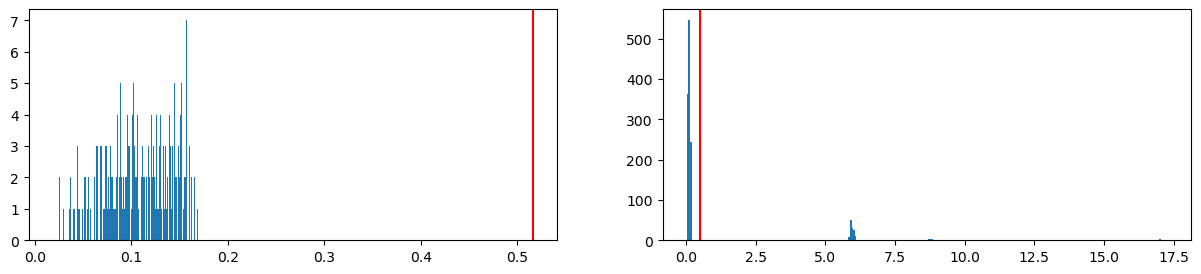

Reconstruction error threshold: 0.5162013668293397



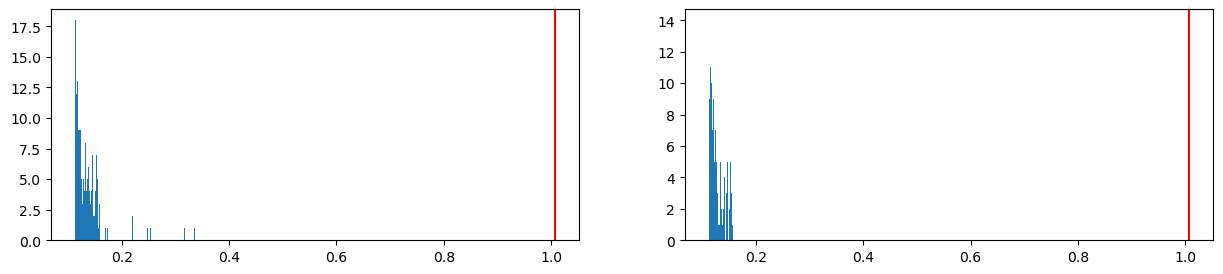

Reconstruction error threshold: 1.0075972532474007



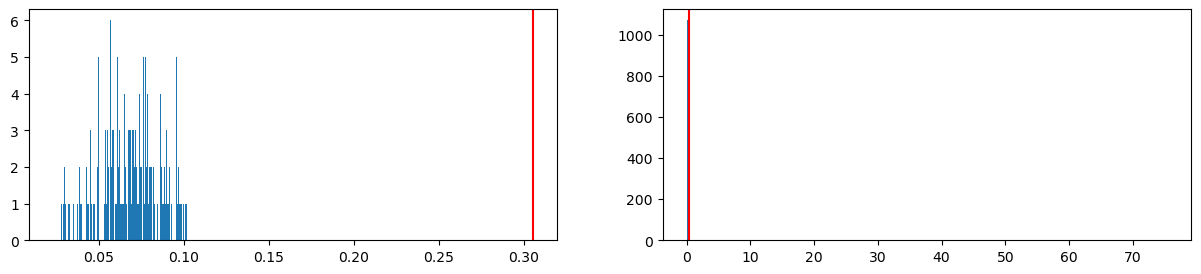

Reconstruction error threshold: 0.3053060396166532



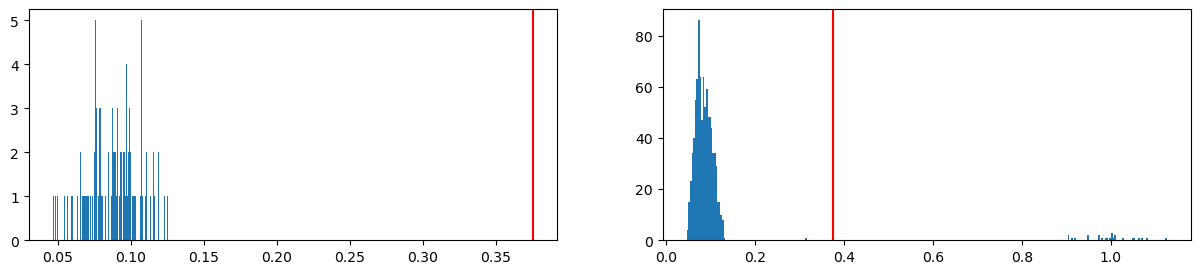

Reconstruction error threshold: 0.375252761893969



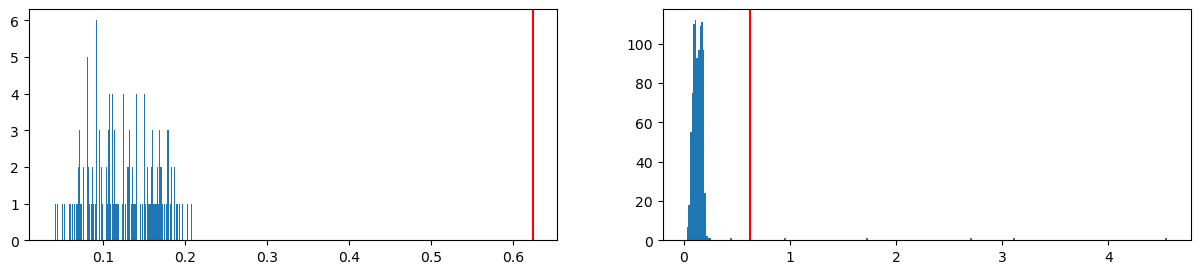

Reconstruction error threshold: 0.6246973928678888



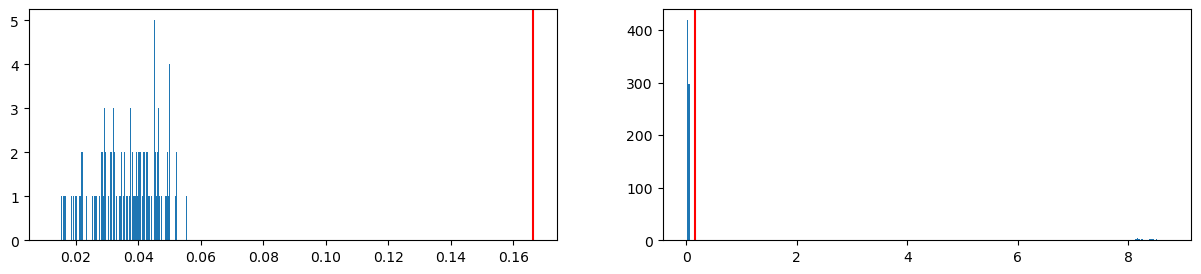

Reconstruction error threshold: 0.16626889962952093



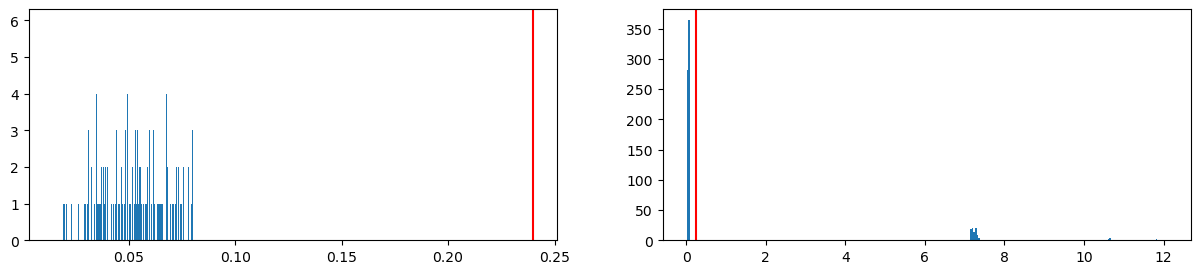

Reconstruction error threshold: 0.23989084340382688



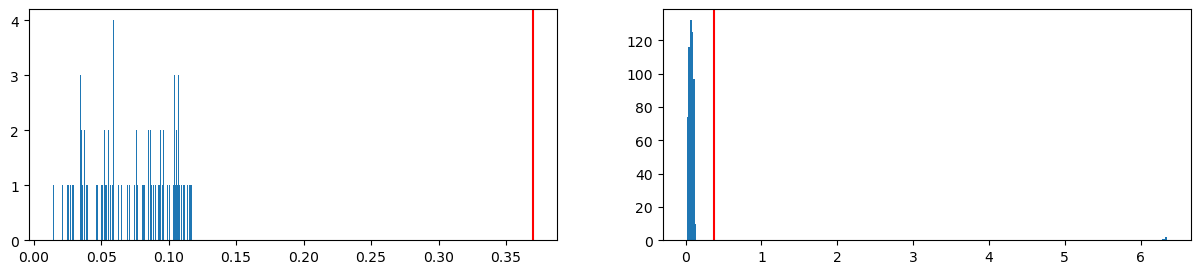

Reconstruction error threshold: 0.36994691166475857



In [8]:
thresholds=threshold_definer(train_dataset, test_dataset, models, bins=300)

# Submission

In [9]:
losses=predict(models, test_dataset, thresholds)
submission.label=np.concatenate((losses))
submission.to_csv(os.path.join(SAVEPATH, time.strftime("%m%d-%H%M.csv")), index=False)

In [10]:
np.concatenate((losses)).sum()

334